In [1]:
pip install datasets

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene as pv

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pyvene as pv
from tqdm.notebook import tqdm
import random
from collections import namedtuple
from copy import deepcopy

In [4]:
%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    theme,
    element_text,
    ggtitle, xlab, ylab
)
from plotnine.scales import scale_y_discrete, scale_fill_cmap

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data preparation

In [29]:
rooms_ds = load_dataset("tasksource/babi_nli", name='compound-coreference')
animals_ds = load_dataset("tasksource/babi_nli", name='basic-deduction')

(…)-00000-of-00001-e45b0345e6bde5a3.parquet:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

(…)-00000-of-00001-1eaa093173accd0c.parquet:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

(…)-00000-of-00001-c669b8101ae16c22.parquet:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [30]:
rooms_ds['train'].to_pandas().head(1)

,premise,hypothesis,label,idx
0,John and Daniel went to the office. After that...,John is in the kitchen.,1,0


In [31]:
animals_ds['train'].to_pandas().head(1)

,premise,hypothesis,label,idx
0,Sheep are afraid of cats. Mice are afraid of c...,Emily is afraid of cat.,1,0


In [32]:
def prepare_last_as_label(data):
    data = deepcopy(data)
    for split in ['train', 'validation', 'test']:
        examples = data[split].filter(lambda x: x['label'] == 0)
        inputs = [ex['premise'] + " " + ex['hypothesis'].rsplit(" ", 1)[0] for ex in examples]
        labels = [ex['hypothesis'].rsplit(" ", 1)[-1].strip('.') for ex in examples]
        data[split] = Dataset.from_dict({'input': inputs, 'label': labels})
    return data

In [33]:
rooms = prepare_last_as_label(rooms_ds)
animals = prepare_last_as_label(animals_ds)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

In [34]:
rooms['train'][0]

{'input': 'Daniel and Sandra went to the office. Following that they travelled to the hallway. Sandra is in the',
 'label': 'office'}

In [35]:
animals['train'][0]

{'input': 'Sheep are afraid of mice. Emily is a sheep. Cats are afraid of mice. Wolves are afraid of cats. Mice are afraid of wolves. Winona is a mouse. Gertrude is a cat. Jessica is a wolf. Emily is afraid of',
 'label': 'cat'}

### Prepare model

In [13]:
model = "EleutherAI/pythia-70m" # "EleutherAI/pythia-6.9B"
tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer.pad_token = tokenizer.eos_token
gpt = AutoModelForCausalLM.from_pretrained(
    model,
    revision="main",
    torch_dtype=torch.bfloat16 if model == "EleutherAI/pythia-6.9b" else torch.float32,
).to(device)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


In [36]:
def probing_config(intervention_site, layer, max_units):
    """Generate intervention config for probing."""
    config = pv.IntervenableConfig([{
        "layer": layer,
        "component": intervention_site,
        "max_number_of_units": max_units,
        "intervention_type": pv.CollectIntervention,
    }])
    return config

In [37]:
def get_label_mapping(labels):
    label_mapping = {label: i for i, label in enumerate(set(labels))}
    return label_mapping

In [38]:
room_label_mapping = get_label_mapping(rooms['train']['label'])
room_label_mapping.keys()

dict_keys(['kitchen', 'bedroom', 'garden', 'bathroom', 'office', 'hallway'])

In [39]:
animals_label_mapping = get_label_mapping(animals['train']['label'])
animals_label_mapping.keys()

dict_keys(['cat', 'wolf', 'sheep', 'mouse'])

In [46]:

def get_relevant_positions(text, tokenizer, labels, context_markers):
    tokens = tokenizer.tokenize(text)
    tokens = [token.replace('Ġ', '') for token in tokens]
    positions = {
        'last': set(),
        'label': set(),
        'name': set(),
        'context': set()
    }

    # Add final position (before room prediction)
    positions['last'].add(len(tokens) - 1)

    # Find positions of label words
    for i, token in enumerate(tokens):
        # Clean token for comparison
        clean_token = token.replace('Ġ', '').lower()
        if clean_token in labels:
            positions['label'].add(i)

    # Find positions of target name words
    target_name = text.split('. ')[-1].split(' ')[0] # Sarah, John, etc.
    target_name_tokens = [token.replace('Ġ', '') for token in tokenizer.tokenize(' '+target_name)]
    for i in range(len(tokens) - len(target_name_tokens) + 1):
        if tokens[i:i+len(target_name_tokens)] == target_name_tokens:
            positions['name'].add(i + len(target_name_tokens) - 1)

    # Find positions of key context phrases
    text_lower = text.lower()
    for marker in context_markers:
        if marker in text_lower:
            # Find position of marker in tokenized sequence
            marker_tokens = [token.replace('Ġ', '') for token in tokenizer.tokenize(' '+marker)]
            for i in range(len(tokens) - len(marker_tokens) + 1):
                if tokens[i:i+len(marker_tokens)] == marker_tokens:
                    positions['context'].add(i + len(marker_tokens) - 1)

    return positions

In [41]:
Example = namedtuple("Example", ["base", "src", "base_label", "src_label", "positions"])

def sample_example(sample, tokenizer, labels, context_markers):
    # get labels
    base_label = sample['label']
    src_label = random.choice([label for label in labels if label != base_label])

    # get texts
    base = sample['input']
    src = base.replace(base_label, src_label)

    # make pairs
    base = tokenizer(base, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    src = tokenizer(src, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

    base_label = tokenizer.encode(" " + base_label)[0]
    src_label = tokenizer.encode(" " + src_label)[0]

    # get relevant positions
    positions = get_relevant_positions(sample['input'], tokenizer, labels, context_markers)

    return Example(base, src, base_label, src_label, positions)

def generate_doable_examples(n, data, model, labels, tokenizer, context_markers):
    examples = []
    iterator = tqdm(range(n))
    i = 0
    while len(examples) < n:
        ex = sample_example(data[i], labels, tokenizer, context_markers)
        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        for k, v in ex.src.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.src[k] = v.to(model.device)

        logits_base = model(**ex.base).logits[0, -1]
        logits_src = model(**ex.src).logits[0, -1]
        if (
            logits_base[ex.base_label] > logits_base[ex.src_label]
            and logits_src[ex.src_label] > logits_src[ex.base_label]
        ):
            examples.append(ex)
            iterator.update(1)
        i +=1
        print(len(examples))

    return examples

### Train probe

In [42]:
def train_eval_probe(model, tokenizer, trainset, evalset, label_mapping):
    # intervention settings
    stats = []
    num_layers = model.config.num_hidden_layers

    label_map = {tokenizer.encode(" " + k)[0]: v for k,v in label_mapping.items()}

    # loop over layers and positions
    with torch.no_grad():
        for layer in tqdm(range(num_layers)):
            for position in ['last', 'label', 'name', 'context']:
                # try:
                print(f"layer: {layer}, position: {position}")

                # set up intervenable model
                config = probing_config("block_output", layer, max_units=32)
                intervenable = pv.IntervenableModel(config, model)
                intervenable.set_device(device)
                intervenable.disable_model_gradients()

                # training loop
                activations, labels = [], []
                for example in trainset:
                    # relevant positions
                    pos_idx = list(example.positions[position])

                    # forward pass
                    base_outputs, _ = intervenable(
                        example.base,
                        unit_locations={"base": pos_idx},
                    )
                    base_activations = base_outputs[1][0]

                    src_outputs, _ = intervenable(
                        example.src,
                        unit_locations={"base": pos_idx},
                    )
                    src_activations = src_outputs[1][0]

                    # collect activation
                    activations.extend(
                        [base_activations.detach()[0].cpu().numpy(), src_activations.detach()[0].cpu().numpy()]
                    )
                    labels.extend([example.base_label, example.src_label])
                labels = [label_map[label] for label in labels]
                # except:
                #     return base_activations

                # train logistic regression
                lr = LogisticRegression(random_state=42, max_iter=1000).fit(
                    activations, labels
                )

                # eval
                activations, labels = [], []
                for example in tqdm(evalset):
                    # relevant positions
                    pos_idx = list(example.positions[position])

                    # forward pass
                    base_outputs, _ = intervenable(
                        example.base,
                        unit_locations={"base": pos_idx},
                    )
                    base_activations = base_outputs[1][0]

                    src_outputs, _ = intervenable(
                        example.src,
                        unit_locations={"base": pos_idx},
                    )
                    src_activations = src_outputs[1][0]

                    # collect activation
                    activations.extend(
                        [base_activations.detach()[0].cpu().numpy(), src_activations.detach()[0].cpu().numpy()]
                    )
                    labels.extend([example.base_label, example.src_label])
                labels = [label_map[label] for label in labels]

                # stats
                acc = lr.score(activations, labels)
                f1 = f1_score(labels, lr.predict(activations), average="macro")
                stats.append({"layer": layer, "position": position, "acc": acc, "f1": f1})
                print(f"acc: {acc:.3%}, f1: {f1:.3f}")
    return pd.DataFrame(stats)

In [43]:
def plot_results(stats_df, title):

    df = pd.DataFrame()
    df["layer"] = stats_df["layer"].astype(int)
    df["pos"] = stats_df["position"].astype("category")
    df["ACC"] = stats_df["acc"].astype(float)
    df["F1"] = stats_df['f1'].astype(float)

    custom_labels = ["last", "label", "name", "context"]
    df['pos'] = pd.Categorical(df["pos"], categories=custom_labels, ordered=True)

    plot = (
        ggplot(df, aes(x="layer", y="pos", fill="ACC"))
        + geom_tile()
        + scale_fill_cmap("Reds") + xlab("layers")
        + scale_y_discrete(labels=custom_labels)
        + theme(figure_size=(5, 3)) + ylab("")
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
        + ggtitle(f"Trained Linear Probe ({title})")
    )
    display(plot)

    plot = (
        ggplot(df, aes(x="layer", y="pos", fill="F1"))
        + geom_tile()
        + scale_fill_cmap("Purples") + xlab("layers")
        + scale_y_discrete(labels=custom_labels)
        + theme(figure_size=(5, 3)) + ylab("")
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
        + ggtitle(f"Trained Linear Probe ({title})")
    )
    display(plot)

Rooms

In [ ]:
rooms_context_markers = ['is in', 'moved to', 'went to', 'travelled to', 'journeyed to', 'went back to']
rooms_trainset = generate_doable_examples(20, rooms['train'], gpt, tokenizer, room_label_mapping.keys(), rooms_context_markers) + generate_doable_examples(10, rooms['validation'], gpt, tokenizer, room_label_mapping.keys(), rooms_context_markers)
rooms_evalset = generate_doable_examples(10, rooms['test'], gpt, tokenizer, room_label_mapping.keys(), rooms_context_markers)

In [48]:
rooms_stats = train_eval_probe(gpt, tokenizer, rooms_trainset, rooms_evalset, room_label_mapping)

  0%|          | 0/6 [00:00<?, ?it/s]

layer: 0, position: last


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 40.000%, f1: 0.260
layer: 0, position: label


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.418
layer: 0, position: name


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 20.000%, f1: 0.107
layer: 0, position: context


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 45.000%, f1: 0.225
layer: 1, position: last


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 55.000%, f1: 0.352
layer: 1, position: label


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.401
layer: 1, position: name


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 25.000%, f1: 0.142
layer: 1, position: context


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 50.000%, f1: 0.310
layer: 2, position: last


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 55.000%, f1: 0.345
layer: 2, position: label


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 50.000%, f1: 0.314
layer: 2, position: name


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 40.000%, f1: 0.193
layer: 2, position: context


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 40.000%, f1: 0.253
layer: 3, position: last


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.550
layer: 3, position: label


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 50.000%, f1: 0.361
layer: 3, position: name


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 50.000%, f1: 0.300
layer: 3, position: context


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 65.000%, f1: 0.562
layer: 4, position: last


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.691
layer: 4, position: label


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 55.000%, f1: 0.373
layer: 4, position: name


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 40.000%, f1: 0.210
layer: 4, position: context


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 65.000%, f1: 0.433
layer: 5, position: last


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 75.000%, f1: 0.727
layer: 5, position: label


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 50.000%, f1: 0.337
layer: 5, position: name


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 45.000%, f1: 0.277
layer: 5, position: context


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


  0%|          | 0/10 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.400


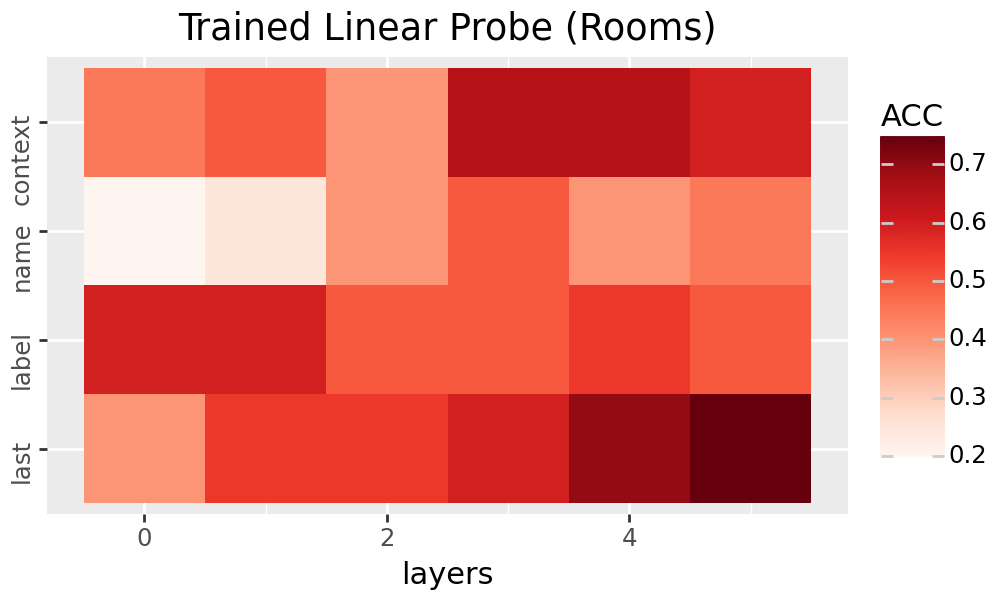

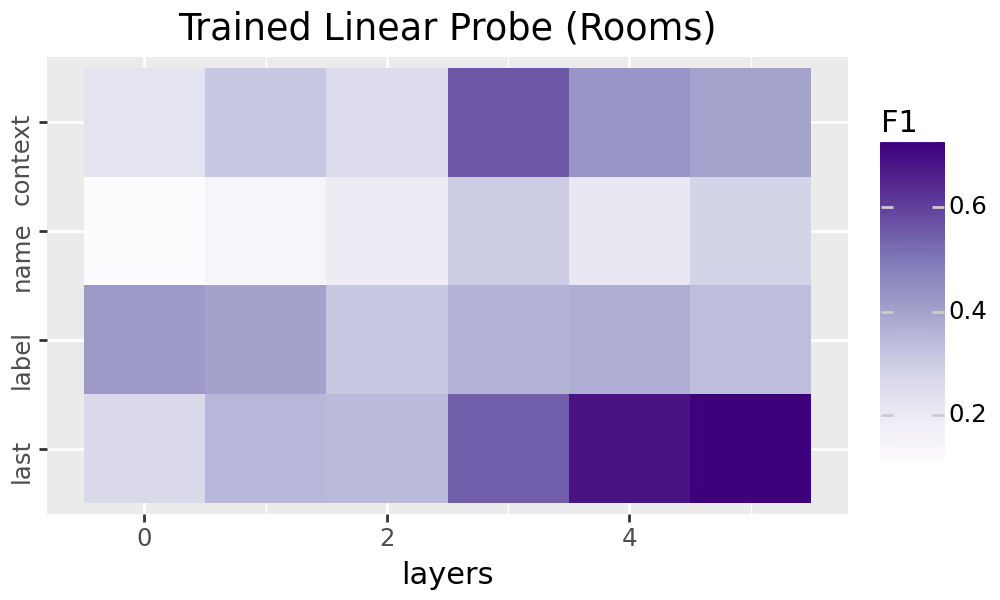

In [49]:
plot_results(rooms_stats, "Rooms")

Colors

In [ ]:
animals_context_markers = ['afraid of', 'is']
animals_trainset = generate_doable_examples(10, animals['train'], gpt, tokenizer, animals_label_mapping.keys(), animals_context_markers) + generate_doable_examples(5, animals['validation'], gpt, tokenizer, animals_label_mapping.keys(), animals_context_markers)
animals_evalset = generate_doable_examples(5, animals['test'], gpt, tokenizer, animals_label_mapping.keys(), animals_context_markers)

In [54]:
animals_stats = train_eval_probe(gpt, tokenizer, animals_trainset, animals_evalset, animals_label_mapping)

  0%|          | 0/6 [00:00<?, ?it/s]

layer: 0, position: last


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 0, position: label


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 0, position: name


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.697
layer: 0, position: context


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.583
layer: 1, position: last


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 1, position: label


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 1, position: name


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.600
layer: 1, position: context


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 2, position: last


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 2, position: label


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 2, position: name


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.600
layer: 2, position: context


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 3, position: last


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.697
layer: 3, position: label


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 3, position: name


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.600
layer: 3, position: context


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 4, position: last


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 4, position: label


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 4, position: name


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.792
layer: 4, position: context


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 5, position: last


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.800
layer: 5, position: label


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 80.000%, f1: 0.792
layer: 5, position: name


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 70.000%, f1: 0.670
layer: 5, position: context


  0%|          | 0/5 [00:00<?, ?it/s]

acc: 60.000%, f1: 0.583


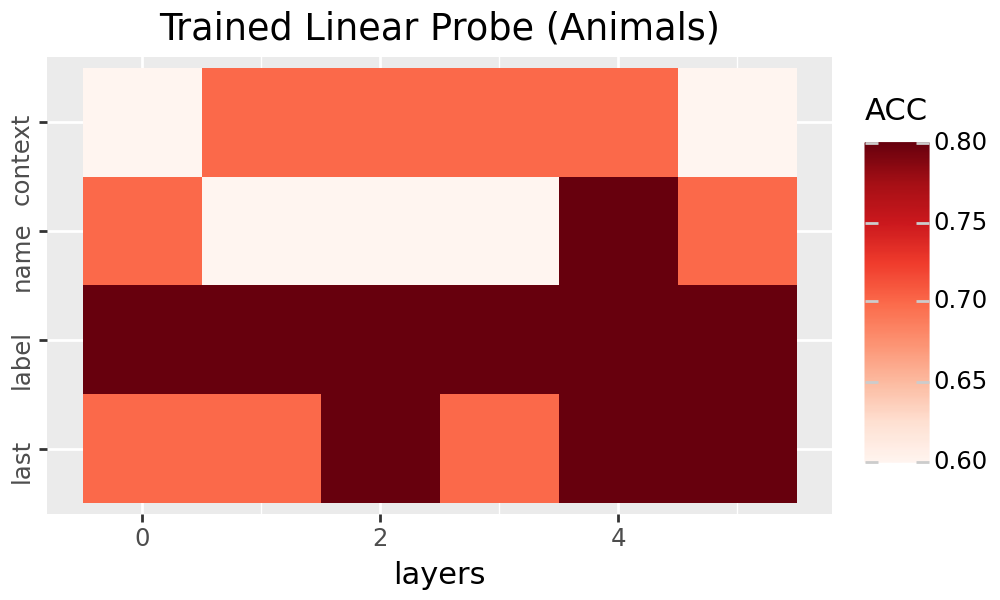

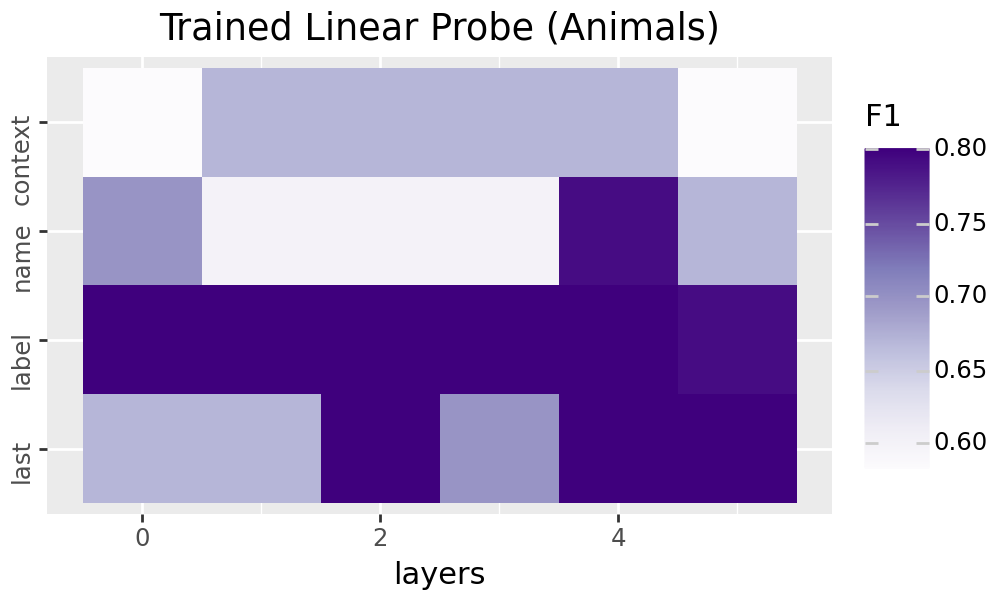

In [55]:
plot_results(animals_stats, "Animals")